# 第16章 文本检测与识别实例
自己生成训练数据，根据选择的数字及小写字母，随机抽取四个字符，通过captcha生成由5随机字符构成的图片。
为简便起见，这里限制了数字及字母范围。

## 16.1 项目架构说明
	本章的OCR项目采用CNN+RNN+CTC(CRNN+CTC)架构，具体如图16-1所示。
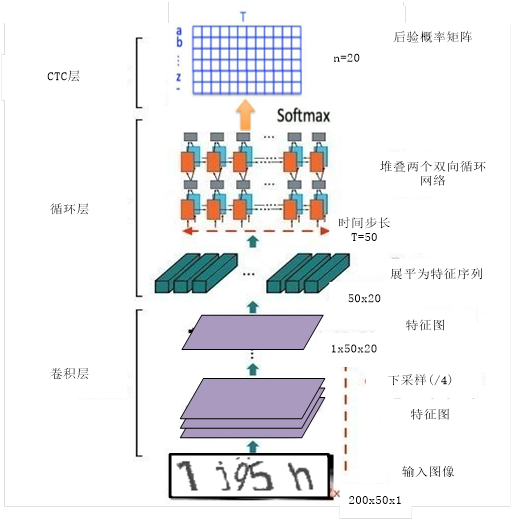
<center>图16-1 CRNN+CTC的架构图</center>

如图16-1所示，输入图像大小为（200,50,1），具体格式为（长，宽，通道数），这里图像进行了预处理，使之变为灰色，即通道数变为1。该架构分为三个部分。  	
1、卷积层   
	这里的卷积层就是一个普通的CNN网络，用于提取输入图像的特征图，即将大小为（200,50,1）的图像转换大小为（1，50,20）的卷积特征矩阵，网络细节请参考本文给出的实现代码。  
2、循环层  
	这里的循环网络层是一个深层双向LSTM网络，在卷积特征的基础上继续提取文字序列特征。  
3、CTC层  
	输出后验概率矩阵，后续的CTC Loss将基于这个矩阵。CTC Loss可解决输出长度与标签长度不等的问题。有关CTC的进一步说明，大家可参考相关论文或博客，这里就不展开来说了。

## 16.2 项目实施步骤
	首先，手工生成训练数据，然后，构建模型，训练模型测试模型。
### 16.2.1 手工生成训练数据
1）导入需要的库。

In [1]:
from captcha.image import ImageCaptcha
import random
import shutil
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2 as cv

2）选择生成5位验证码的数字及字母。

In [2]:
#选择9个自然数
number = [ '1', '2', '3', '4', '5', '6', '7', '8', '9']
#alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't','u',
#            'v', 'w', 'x', 'y', 'z']
#选择9个小写字母
alphabet = [ 'a', 'd',  'h', 'j', 'k', 'q', 's', 't', 'y']

CHAR_SET = number + alphabet
CHAR_SET_LEN = len(CHAR_SET)
IMAGE_HEIGHT = 50
IMAGE_WIDTH = 160

## 随机生成数据集

In [3]:
## 创建保存训练数据集的目录
save_path='ocr_data/'
shutil.rmtree(save_path,ignore_errors=True)
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [4]:
def random_captcha_text(char_set=None, captcha_size=5):
    if char_set is None:
        char_set = number + alphabet

    captcha_text = []
    for i in range(captcha_size):
        c = random.choice(char_set)
        captcha_text.append(c)
    return captcha_text


def gen_captcha_text_and_image(width=200, height=50, char_set=CHAR_SET):
    image = ImageCaptcha(width=width, height=height)
    # 然后再使用create_noise_curve方法将上面生成的验证码画上干扰线
    #image = image.create_noise_curve(image, color='black')
    captcha_text = random_captcha_text(char_set)
    captcha_text = ''.join(captcha_text)
    captcha= image.create_captcha_image(captcha_text,color='red', background='white')
    captcha = image.create_noise_curve(captcha, color='black')
    captcha.save(save_path+captcha_text+".png")
    return captcha_text, captcha


In [5]:
## 生成3000个验证码图片
for i in range(3000):
    text, image = gen_captcha_text_and_image(char_set=CHAR_SET)    